# Solutions - Home Assignment 

### 1.0 Setup

In [1]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 1.1 Exercise A:

#### 1.1.1 A.i):

Read in the provided data.

In [2]:
# read in the data sheet
random = pd.read_csv('randomX.csv')

# display the data
random.head()

,x1,x2,x3
0,0.537667,0.840376,0.183227
1,1.833885,-0.888032,-1.029768
2,-2.258847,0.100093,0.949222
3,0.862173,-0.544529,0.307062
4,0.318765,0.303521,0.135175


First, write a function that obtains `M` Monte-Carlo samples of the data.

In [3]:
# define a function that simulates the data
def simul(M, N, X, α, β):
    
    Y = np.empty([N, M])
    
    # generate Y based on the input parameters
    Y = α + β* np.tile(X, (1, M)) + np.random.randn(N, M)
        
    # return the matrix of generated data
    return Y


Now, obtain `M` MC samples of length `N` and with input parameters `α` and `β`.

In [4]:
# set the simulation parameters
N = len(random.x1)
M = 2000

# obtain a sample of simulated data
Y_MC = simul(M, N, np.asarray(random.x1)[:,None], 0.5, 1.5)


With the samples generated, now compute the regression. You can either use a version of the OLS class provided as a solution to the homework problems/tutorial or a Python package. 

#### Implementation with `class OLS`:

In [5]:
class OLS:

    """
    This code implements a simple OLS regression. The inputs Y and X must be in numpy matrix format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')

    def estimate(self):
        #unpack Y and X
        Y, X = self.Y, self.X
        
        #Estimate the beta coefficients
        self.beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)
        
        #compute the regression residuals
        eps = Y - X @ self.beta
        
        #compute the residual variance
        s_hat = 1/(Y.shape[0]-self.beta.shape[0]) * eps.T @ eps
        
        #compute the standard errors
        self.se = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_hat.item())).reshape((self.beta.shape[0],1))
        
        #compute t-statistic for standard hypothesis test
        t = np.abs(self.beta/self.se)

        #compute p-values for standard hypothesis test
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
             
        #compute confidence intervals
        CI_upper = self.beta + stats.norm.ppf(0.975)*self.se
        CI_lower = self.beta - stats.norm.ppf(0.975)*self.se
        
        MSE = np.mean(np.square(eps),axis=0)
        self.R2 = 1 - MSE/np.var(Y)
        self.eps = eps
        self.s_hat = s_hat
        
        #generate an output table
        outmat = np.hstack((self.beta,self.se,t,p_vals,CI_lower,CI_upper))
        table = pd.DataFrame(outmat)
        table.columns =['beta', 'se','t-statistic','p-value','CI - lower','CI - upper'] 
        
        return table
    

Set up the `X` and `Y` arrays of independent and dependent variables, respectively. Since we need to estimate the model for all MC samples, we need to use a loop.

In [6]:
# set up the matrix of independent variables. Setting up the matrix outside of the loop speeds up the code.
X = np.hstack((np.ones([Y_MC.shape[0],1]),(np.asarray(random.x1)[:,None]), (np.asarray(random.x2)[:,None]), (np.asarray(random.x3)[:,None]), (np.asarray(random.x3)[:,None])**2))

# initialize the output matrices for the betas and R^2
betas = np.empty([X.shape[1], Y_MC.shape[1]])
R2s = np.empty([1, Y_MC.shape[1]])

# run the regression for every Y in the MC exercise
for i in range(M):
    
    # read out the corresponding column of Y
    Y = np.asarray(Y_MC[:,i])[:,None]
    
    # run the regression
    MC_beta = OLS(Y,X)
    MC_beta.estimate()
    
    # store the betas and R2 in the output arrays
    betas[:,i] = MC_beta.beta.ravel()
    R2s[0,i] = MC_beta.R2
    

Plot histograms for the parameters.

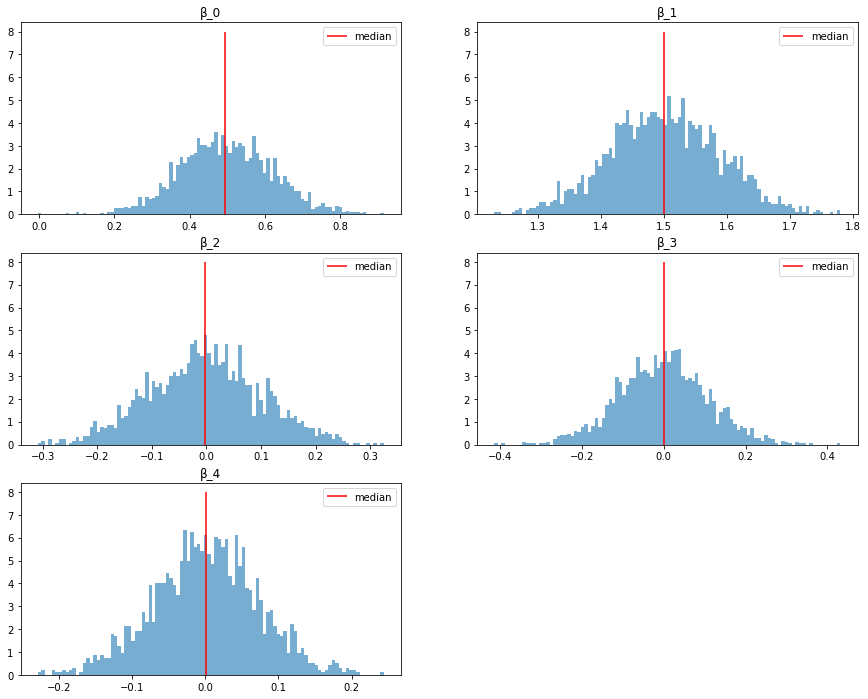

In [7]:
# arrange the plots in 2-by-2 subplots
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# plot the historgrams for the parameters
id_ = 0

for i in range(num_rows):    
    for j in range(num_cols):
        if id_ <= betas.shape[0]-1:
            axes[i, j].hist(betas[id_,:], alpha=0.6, bins=100, density=True)
            axes[i, j].vlines(np.median(betas[id_,:]),0,8,colors='r',label='median')
            t = 'β_%.0f' %(id_)   
            axes[i, j].set(title=t)
            axes[i, j].legend()
            id_ = id_ + 1
fig.delaxes(axes[2, 1])
plt.show()



Plot the histogram for $R^2$.

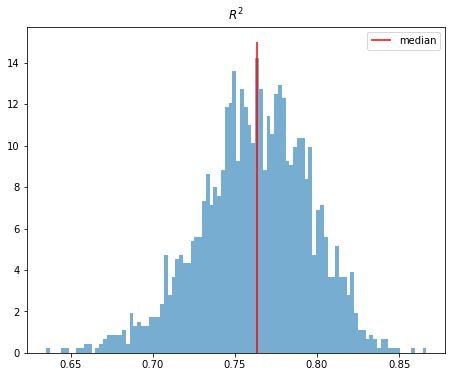

In [8]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the historgrams for the R^2
axes.hist(R2s[0,:], alpha=0.6, bins=100, density=True)
axes.vlines(np.median(R2s[0,:]),0,15,colors='r',label='median')
t = r'$R^2$'   
axes.set(title=t)
axes.legend()
plt.show()


#### Implementation with `statsmodels`:

Set up the `X` and `Y` arrays of independent and dependent variables, respectively. Since we need to estimate the model for all MC samples, we need to use a loop.

In [9]:
# set up the matrix of independent variables. Setting up the matrix outside of the loop speeds up the code.
X = np.hstack((np.ones([Y_MC.shape[0],1]),(np.asarray(random.x1)[:,None]), (np.asarray(random.x2)[:,None]), (np.asarray(random.x3)[:,None]), (np.asarray(random.x3)[:,None])**2))

# initialize the output matrices for the betas and R^2
betas = np.empty([X.shape[1], Y_MC.shape[1]])
R2s = np.empty([1, Y_MC.shape[1]])

# run the regression for every Y in the MC exercise
for i in range(M):
    
    # read out the corresponding column of Y
    Y = np.asarray(Y_MC[:,i])[:,None]
    
    # run the regression
    model = sm.OLS(Y, X)
    results = model.fit()
    
    # store the betas and R2 in the output arrays
    betas[:,i] = results.params.ravel()
    R2s[0,i] = results.rsquared

Plot the histograms for the parameters.

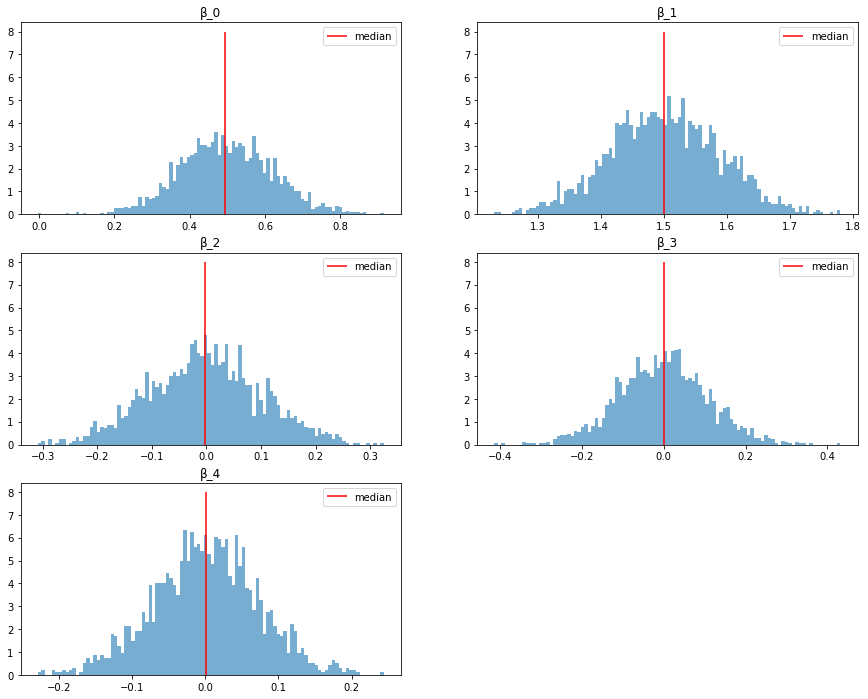

In [10]:
# arrange the plots in 2-by-2 subplots
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# plot the historgrams for the parameters
id_ = 0

for i in range(num_rows):    
    for j in range(num_cols):
        if id_ <= betas.shape[0]-1:
            axes[i, j].hist(betas[id_,:], alpha=0.6, bins=100, density=True)
            axes[i, j].vlines(np.median(betas[id_,:]),0,8,colors='r',label='median')
            t = 'β_%.0f' %(id_)   
            axes[i, j].set(title=t)
            axes[i, j].legend()
            id_ = id_ + 1
fig.delaxes(axes[2, 1])
plt.show()


Plot the histogram for $R^2$.

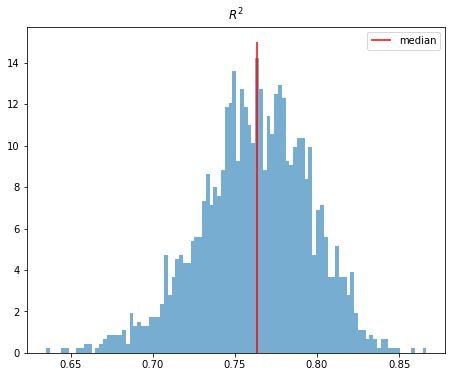

In [11]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the historgrams for the R^2
axes.hist(R2s[0,:], alpha=0.6, bins=100, density=True)
axes.vlines(np.median(R2s[0,:]),0,15,colors='r',label='median')
t = r'$R^2$'   
axes.set(title=t)
axes.legend()
plt.show()


#### 1.1.2 A.ii):

To construct confidence bands based on the MC simulation, we simply need to compute the percentiles of the parameter distributions.

In [12]:
# compute the confidence intervals
CI = np.hstack((np.percentile(betas, 5, axis = 1)[:,None], np.percentile(betas, 95, axis = 1)[:,None]))

# display the condidence intervals
print('The MC confidence intervals are: \n' + str(CI))

The MC confidence intervals are: 
[[ 0.30253138  0.70160033]
 [ 1.35635118  1.64308284]
 [-0.17106081  0.17073801]
 [-0.18243879  0.17693446]
 [-0.12012698  0.11916799]]


#### 1.1.3 A.iii): 

First, we need to set up a new `X` matrix of independent variables. Then we simply repeat our procedures from above. 

#### Implementation with `class OLS`:

Run the OLS regressions as before.

In [13]:
# set up the matrix of independent variables. Setting up the matrix outside of the loop speeds up the code.
X = np.hstack((np.ones([Y_MC.shape[0],1]),(np.asarray(random.x1)[:,None])))

# initialize the output matrices for the betas and R^2
betas = np.empty([X.shape[1], Y_MC.shape[1]])
R2s = np.empty([1, Y_MC.shape[1]])

# run the regression for every Y in the MC exercise
for i in range(M):
    
    # read out the corresponding column of Y
    Y = np.asarray(Y_MC[:,i])[:,None]
    
    # run the regression
    MC_beta = OLS(Y,X)
    MC_beta.estimate()
    
    # store the betas and R2 in the output arrays
    betas[:,i] = MC_beta.beta.ravel()
    R2s[0,i] = MC_beta.R2
    

Plot the histograms for $\beta_1$.


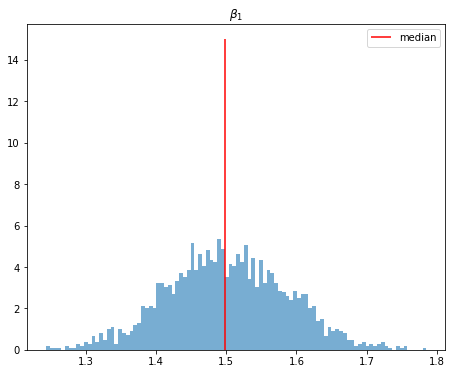

In [14]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the historgrams for the R^2
axes.hist(betas[1,:], alpha=0.6, bins=100, density=True)
axes.vlines(np.median(betas[1,:]),0,15,colors='r',label='median')
t = r'$\beta_1$'   
axes.set(title=t)
axes.legend()
plt.show()


#### Implementation with `statsmodels`:

Run the OLS regressions as before.

In [15]:
# set up the matrix of independent variables. Setting up the matrix outside of the loop speeds up the code.
X = np.hstack((np.ones([Y_MC.shape[0],1]),(np.asarray(random.x1)[:,None])))

# initialize the output matrices for the betas and R^2
betas = np.empty([X.shape[1], Y_MC.shape[1]])
R2s = np.empty([1, Y_MC.shape[1]])

# run the regression for every Y in the MC exercise
for i in range(M):
    
    # read out the corresponding column of Y
    Y = np.asarray(Y_MC[:,i])[:,None]
    
    # run the regression
    model = sm.OLS(Y, X)
    results = model.fit()
    
    # store the betas and R2 in the output arrays
    betas[:,i] = results.params.ravel()
    R2s[0,i] = results.rsquared

Plot the histograms for $\beta_1$.

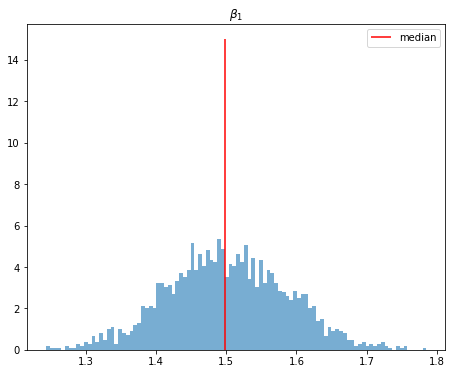

In [16]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the historgrams for the R^2
axes.hist(betas[1,:], alpha=0.6, bins=100, density=True)
axes.vlines(np.median(betas[1,:]),0,15,colors='r',label='median')
t = r'$\beta_1$'    
axes.set(title=t)
axes.legend()
plt.show()


#### 1.1.4 A.iv):

#### 1.1.5 A.v):

#### 1.1.6 A.vi):

The below code is one of many possible solutions.

In [17]:
from ipywidgets import *

In [18]:
def size_effect(M=100):
    
    # obtain a sample of simulated data
    Y_MC_ = simul(M, N, np.asarray(random.x1)[:,None], 0.5, 1.5)
    
    # -------------------------------- generate R^2 for the first regression ------------------------------#
    
    # set up the matrix of independent variables. Setting up the matrix outside of the loop speeds up the code.
    X = np.hstack((np.ones([Y_MC.shape[0],1]),(np.asarray(random.x1)[:,None]), (np.asarray(random.x2)[:,None]), (np.asarray(random.x3)[:,None]), (np.asarray(random.x3)[:,None])**2))

    # initialize the output matrices for the betas and R^2
    betas = np.empty([X.shape[1], M])
    R2s = np.empty([1, Y_MC_.shape[1]])

    # run the regression for every Y in the MC exercise
    for i in range(M):
    
        # read out the corresponding column of Y
        Y = np.asarray(Y_MC[:,i])[:,None]
    
        # run the regression
        model = sm.OLS(Y, X)
        results = model.fit()
    
        # store R2 in the output arrays
        R2s[0,i] = results.rsquared
        betas[:,i] = results.params.ravel()
    
    
    fig, axes = plt.subplots()
    #axes.plot(Y_MC_[0,:])
    axes.hist(betas[1,:], alpha=0.5, bins=100, density=True)
    axes.vlines(np.median(betas[1,:]),0,15,colors='r',label='median first regression')
    
    # -------------------------------- generate R^2 for the second regression ------------------------------#
    
    
    # set up the matrix of independent variables. Setting up the matrix outside of the loop speeds up the code.
    X = np.hstack((np.ones([Y_MC.shape[0],1]),(np.asarray(random.x1)[:,None])))

    # initialize the output matrices for the betas and R^2
    betas = np.empty([X.shape[1], M])
    R2s = np.empty([1, Y_MC_.shape[1]])

    # run the regression for every Y in the MC exercise
    for i in range(M):
    
        # read out the corresponding column of Y
        Y = np.asarray(Y_MC[:,i])[:,None]
    
        # run the regression
        model = sm.OLS(Y, X)
        results = model.fit()
    
        # store the betas and R2 in the output arrays
        betas[:,i] = results.params.ravel()
        R2s[0,i] = results.rsquared

    axes.hist(betas[1,:], alpha=0.5, bins=100, density=True)
    axes.vlines(np.median(betas[1,:]),0,15,colors='k',label='median second regression')
    axes.legend()
    
    return plt.show()

slider = interactive(size_effect, M =(100, 2000, 100))
 
#display the resulting slider
display(slider)

interactive(children=(IntSlider(value=100, description='M', max=2000, min=100, step=100), Output()), _dom_clas…

### 1.2 Exercise B:

#### 1.2.1 B.i):

Read in the provided data.

In [2]:
# read in the data sheet
varekonsum = pd.read_excel('varekonsum.xlsx', usecols="C:IT", header=3).T
varekonsum = varekonsum.dropna(axis=1)

# adjust columnlabel
varekonsum.columns =['varekonsum']

# replace the index with a machine readable format
varekonsum.index = pd.date_range(start='31/01/2000', end='31/12/2020', freq='M')

# display the data
varekonsum.head()

,varekonsum
2000-01-31,77.1
2000-02-29,75.8
2000-03-31,80.7
2000-04-30,76.2
2000-05-31,83.4


Plot the data.

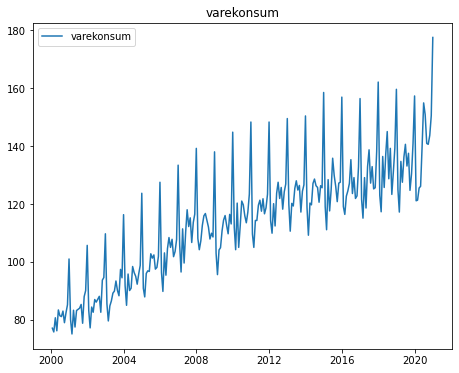

In [20]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the data
axes.plot(varekonsum.index,varekonsum.varekonsum, label='varekonsum')
axes.set(title='varekonsum')
axes.legend()
plt.show()

#### 1.2.2 B.ii):

Create a December `dummy`.

In [21]:
# with the index in datetime, we can easily create a dummy using logical operators
varekonsum['dum'] = list(map(int, varekonsum.index.month == 12))
varekonsum.head()

,varekonsum,dum
2000-01-31,77.1,0
2000-02-29,75.8,0
2000-03-31,80.7,0
2000-04-30,76.2,0
2000-05-31,83.4,0


#### 1.2.3 B.iii):

#### Implementation with `class OLS`:

In [22]:
# set up the vector containing the dependent variable
Y = np.asarray(varekonsum.varekonsum)[:,None]

# set up the matrix of independent variables. 
X = np.hstack((np.ones([Y.shape[0],1]), (np.arange(1, Y.shape[0]+1, 1)[:,None]), (np.asarray(varekonsum.dum)[:,None])))

Run the OLS regression.

In [23]:
# run the regression
beta = OLS(Y,X)
beta.estimate()

,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,81.770515,0.817937,99.971668,0.0,80.167388,83.373642
1,0.233684,0.005559,42.033766,0.0,0.222788,0.244580
2,28.530796,1.463263,19.498065,0.0,25.662853,31.398738


Plot the residuals.

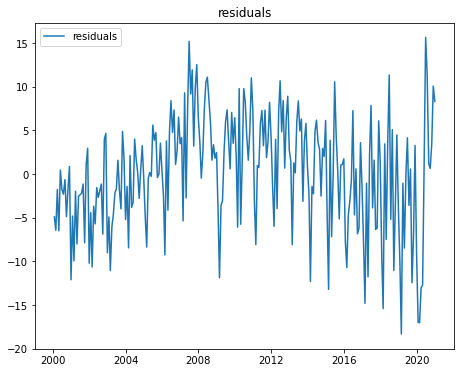

In [24]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the data
axes.plot(varekonsum.index,beta.eps, label='residuals')
axes.set(title='residuals')
axes.legend()
plt.show()

#### Implementation with `statsmodels`:

In [25]:
# set up the vector containing the dependent variable
Y = np.asarray(varekonsum.varekonsum)[:,None]

# set up the matrix of independent variables. 
X = np.hstack((np.ones([Y.shape[0],1]), (np.arange(1, Y.shape[0]+1, 1)[:,None]), (np.asarray(varekonsum.dum)[:,None])))

Run the OLS regression.

In [26]:
# run the regression
model = sm.OLS(Y, X)
results = model.fit()

Plot the residuals.

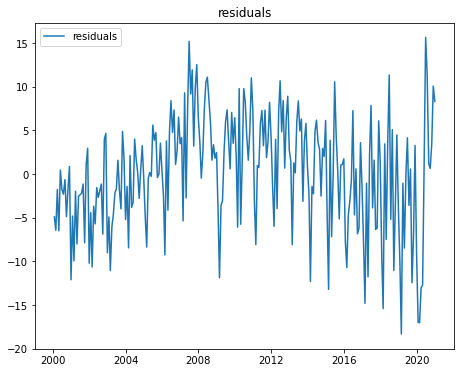

In [27]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the data
axes.plot(varekonsum.index,results.resid, label='residuals')
axes.set(title='residuals')
axes.legend()
plt.show()

#### 1.2.4 B.iv):

We first have to compute the year-on-year growth rates. 

In [28]:
# compute year-on-year log differences
varekonsum['d12y'] = np.log(varekonsum.varekonsum).diff(12)

# drop the missing values that arise due to differencing
varekonsum = varekonsum.dropna(axis=0)
varekonsum.head()

,varekonsum,dum,d12y
2001-01-31,80.0,0,0.036923
2001-02-28,75.1,0,-0.009278
2001-03-31,83.3,0,0.031710
2001-04-30,77.5,0,0.016916
2001-05-31,83.2,0,-0.002401


Plot the series.

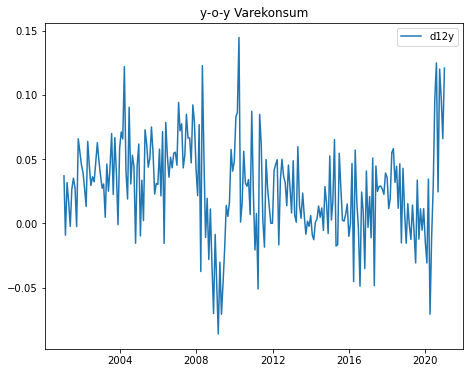

In [29]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the data
axes.plot(varekonsum.index,varekonsum.d12y, label='d12y')
axes.set(title='y-o-y Varekonsum')
axes.legend()
plt.show()

#### 1.2.5 B.v):

#### Implementation with `class OLS`:

In [30]:
# set up the vector containing the dependent variable
Y = np.asarray(varekonsum.d12y[1:])[:,None]

# set up the matrix of independent variables. 
X = np.hstack((np.ones([Y.shape[0],1]), np.asarray(varekonsum.d12y[:-1])[:,None]))

Run the OLS regression.

In [31]:
# run the regression
beta = OLS(Y,X)
beta.estimate()

,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,0.018014,0.002818,6.391915,1.638210e-10,0.012490,0.023538
1,0.332456,0.062188,5.345970,8.993419e-08,0.210569,0.454342


#### Implementation with `statsmodels`:

In [32]:
# set up the vector containing the dependent variable
Y = np.asarray(varekonsum.d12y[1:])[:,None]

# set up the matrix of independent variables. 
X = np.hstack((np.ones([Y.shape[0],1]), np.asarray(varekonsum.d12y[:-1])[:,None]))

Run the OLS regression.

In [33]:
# run the regression
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     28.58
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           2.11e-07
Time:                        23:18:59   Log-Likelihood:                 460.58
No. Observations:                 239   AIC:                            -917.2
Df Residuals:                     237   BIC:                            -910.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0180      0.003      6.392      0.0

#### 1.2.6 B.vi):

First we need to write some code that allows us to choose the order of the AR process flexibly, estimates the OLS regression and computes the BIC.

#### Implementation with `class OLS`:

In [34]:
# write a function that generates the regression matrices for an AR(p)
def AR(data, p):
    Y = np.asarray(data.d12y[p:])[:,None]
    X = np.ones([Y.shape[0],1])
    
    # we now simply need to stack the other AR coefficients onto the 
    for i in np.arange(1,p+1,1):
        X = np.hstack((X, np.asarray(data.d12y[p-i:-i])[:,None]))
        
    return Y, X


# write a function that returns the BIC for every AR(p) process
def BIC(data, max_p):
    
    # inititlaize the matrix
    BIC_ = np.empty([max_p, 1])
    
    for i in np.arange(max_p)+1:
        # obtain Y and X
        Y, X = AR(data, i)
        
        # run OLS regression
        beta = OLS(Y,X)
        beta.estimate()
        
        # degrees of freedom adjustment
        k = X.shape[1] + 1
        
        # compute BIC
        BIC_[i-1] = Y.shape[0] * np.log(beta.s_hat) + (X.shape[1]+1)*np.log(Y.shape[0])
    
    p_opt = np.argmin(BIC_) + 1
    
    return BIC_, p_opt

Compute the BIC for each lag length and obtain the `argmin`. 

In [35]:
BIC_, p_opt = BIC(varekonsum,10)

print('The optimal lag length is:\n p = ' + str(p_opt))

The optimal lag length is:
 p = 3


#### Implementation with `statsmodels`:

In [36]:
# write a function that generates the regression matrices for an AR(p)
def AR(data, p):
    Y = np.asarray(data.d12y[p:])[:,None]
    X = np.ones([Y.shape[0],1])
    
    # we now simply need to stack the other AR coefficients onto the 
    for i in np.arange(1,p+1,1):
        X = np.hstack((X, np.asarray(data.d12y[p-i:-i])[:,None]))
        
    return Y, X


# write a function that returns the BIC for every AR(p) process
def BIC(data, max_p):
    
    # inititlaize the matrix
    BIC_ = np.empty([max_p, 1])
    
    for i in np.arange(max_p)+1:
        # obtain Y and X
        Y, X = AR(data, i)
        
        # run OLS regression
        model = sm.OLS(Y, X)
        results = model.fit()
        
        # compute the BIC
        BIC_[i-1] = results.bic 
        p_opt = np.argmin(BIC_) + 1
    
    return BIC_, p_opt

Compute the BIC for each lag length and obtain the `argmin`. 

In [37]:
BIC_, p_opt = BIC(varekonsum,10)
print('The optimal lag length is:\n p = ' + str(p_opt))

The optimal lag length is:
 p = 3


### 1.3 Exercise C:

#### 1.3.1 C.i):

In [38]:
# read-in the data
financial_data = pd.read_csv('2018_Financial_Data.csv')

In [39]:
# set company name as index
financial_data = financial_data.set_index('Unnamed: 0')

# convert sector to categorical
financial_data["Sector"] = financial_data["Sector"].astype('category')
financial_data["Sector"] = financial_data["Sector"].cat.codes

Replace missing values with `0`.

In [40]:
# replace missing values with 0
financial_data = financial_data.fillna(0)
financial_data

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,2,32.794573,1
KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,4,40.588068,1
INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,9,30.295514,1
MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,9,64.213737,1
GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,-2.177200e+10,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,7,44.757840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YRIV,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,3.755251e+06,-3.755251e+06,1.105849e+07,-1.482451e+07,...,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602,8,-90.962099,0
YTEN,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,9.830000e+06,-9.274000e+06,0.000000e+00,-9.170000e+06,...,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993,0,-77.922077,0
ZKIN,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,8.672953e+06,9.617636e+06,1.239170e+06,8.416324e+06,...,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987,0,-17.834400,0


#### 1.3.2 C.ii):

First, we have to read out `Y` (Dividend payments) and `X`.

In [41]:
Y = np.asarray(financial_data['Dividend payments'])
X = np.asarray(financial_data.loc[:, financial_data.columns != 'Dividend payments'])

In [42]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

Then, we have to standardize the data.

In [43]:
# use sklearn to standardize the data for the Lasso analysis
Y_std = StandardScaler()
Y_std.fit(Y[:,None])
Y_std = Y_std.transform(Y[:,None])

X_std = StandardScaler()
X_std.fit(X)
X_std = X_std.transform(X)

We can now run the Lasso with 5-fold CV.

In [44]:
# define the LassoCV object
Lasso = LassoCV(cv=5, fit_intercept=False, normalize=False, max_iter=10000).fit(X_std, Y_std.ravel())
print('The optimal alpha is: '+ str(Lasso.alpha_))

The optimal alpha is: 0.019546258457516154


#### 1.3.3 C.iii):

#### 1.3.3 C.iv):

We can now read out $R^2$, as well as all the variables that are included. 

In [45]:
print('The R^2 is:\n' + str(Lasso.score(X_std, Y_std.ravel())))

The R^2 is:
0.8149472235807809


And create a table containing all variables and their corresponding coefficients.

In [46]:
# get the columns labels without 'Dividend payments'
ccc = financial_data.loc[:, financial_data.columns != 'Dividend payments'].columns

pd.DataFrame(Lasso.coef_, index=ccc, columns=['coefficient'])

,coefficient
Revenue,-0.000000
Revenue Growth,-0.000000
Cost of Revenue,0.000000
Gross Profit,-0.038286
R&D Expenses,-0.042864
...,...
R&D Expense Growth,-0.000000
SG&A Expenses Growth,-0.000000
Sector,-0.000000
2019 PRICE VAR [%],0.000000


Since there are many variables in our data set, let us present only those that have a non-zero coefficient.

In [47]:
# get a list of all variables that are included in the active set
pd.DataFrame(Lasso.coef_[Lasso.coef_ != 0], index=ccc[Lasso.coef_ != 0], columns=['coefficient'])

,coefficient
Gross Profit,-0.038286
R&D Expenses,-0.042864
Earnings before Tax,-0.179280
Income Tax Expense,-0.097934
Net Income - Non-Controlling int,-0.030274
Net Income - Discontinued ops,-0.013497
Preferred Dividends,-0.026095
Weighted Average Shs Out (Dil),-0.018125
Dividend per Share,-0.062493
EBIT,-0.134758


#### 1.3.4 C.v) and C.vi):

For this exercise we can again use one of the classes provided as a solution to a tutorial or a Python toolbox.

#### Implementation with `class PCA`: 

In [48]:
class PCA:
    
    def __init__(self, X):
        self.X = X

    def get_components(self, X = None, kk = 1, λ = None):
        
        # build the function such that it can also back out the factors given the loadings for arbitrary samples
        if X is None:
            X = self.X
            
        if λ is not None:
            # back out the size of the data
            [t,n] = X.shape
            
            self.λ = λ
            self.f = X @ self.λ /n
        else:
            #X = self.X
            
            # back out the size of the data
            [t,n] = X.shape

            # since the data is standardized, we can compute the variance-covariance matrix like so
            covm = X.T @ X

            # now we extract the eigenvectors and eigenvalues
            w,v = np.linalg.eig(covm)

            # sort in descending order
            sort_id = np.flipud(np.argsort(w))
            v = v[:,sort_id]
            # diagonalize eigenvalues
            w = np.diag(w[sort_id])
    
            # compute the factor loadings
            self.λ = np.sqrt(n)*v[:,0:kk]

            # compute the principal components
            self.f = X @ self.λ /n
            
        self.λ = self.λ.real
        self.f = self.f.real
        

With the class set up, we can now generate the principal component. 

In [49]:
k = 1 

PCA_ = PCA(X_std)
PCA_.get_components(X_std,k)

Plot the principal component.

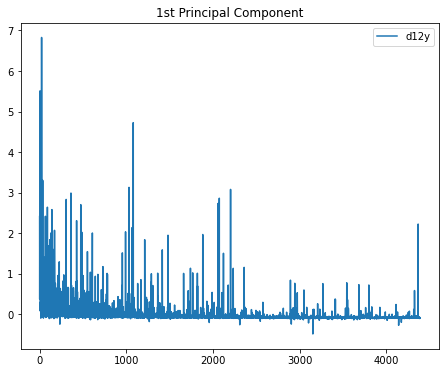

In [50]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the data
axes.plot(PCA_.f, label='d12y')
axes.set(title='1st Principal Component')
axes.legend()
plt.show()

We can now regress `Y` onto the principal component. Since we work with standardized data, we do not have to include a constant.

In [51]:
X = np.hstack((np.ones([Y_std.shape[0],1]), PCA_.f))

# run the regression
beta = OLS(Y_std,PCA_.f)
beta.estimate()

,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,-2.37512,0.028945,82.056133,0.0,-2.431852,-2.318389


In [52]:
print('The R^2 is:\n' + str(beta.R2.item()))

The R^2 is:
0.6052753035889729


#### Implementation with `scikit learn`:

Obtain the principal component.

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(X_std)

FF = pca.fit_transform(X_std)

Plot the principal component.

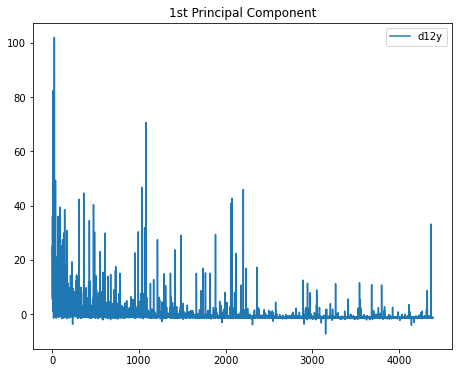

In [54]:
fig, axes = plt.subplots(figsize=(7.5, 6))

# plot the data
axes.plot(FF, label='d12y')
axes.set(title='1st Principal Component')
axes.legend()
plt.show()

We can now regress Y onto the principal component. Since we work with standardized data, we do not have to include a constant.

In [55]:
# run the regression
model = sm.OLS(Y_std, FF)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.605
Model:                            OLS   Adj. R-squared (uncentered):              0.605
Method:                 Least Squares   F-statistic:                              6733.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):                        0.00
Time:                        23:19:01   Log-Likelihood:                         -4190.6
No. Observations:                4392   AIC:                                      8383.
Df Residuals:                    4391   BIC:                                      8390.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### 1.3.5 C.vii):